In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [3]:
print('Reading train dataset (Train 60000.cdb)...')
x_train, y_train = read_hoda_dataset(dataset_path='./dataset/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=False)


print('Reading test dataset (Test 20000.cdb)...')
x_test, y_test = read_hoda_dataset(dataset_path='./dataset/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)


print('Reading remaining samples dataset (RemainingSamples.cdb)...')
x_remaining, y_remaining = read_hoda_dataset('./dataset/RemainingSamples.cdb',
                                             images_height=32,
                                             images_width=32,
                                             one_hot=True,
                                             reshape=True)

Reading train dataset (Train 60000.cdb)...


C:\Users\MR.EIGHT\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Reading test dataset (Test 20000.cdb)...
Reading remaining samples dataset (RemainingSamples.cdb)...


In [4]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 1)



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 32, 32, 1, 1)
60000 train samples
20000 test samples


In [5]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                4

In [8]:
x_test.shape

(20000, 32, 32, 1, 1)

In [9]:
y_test.shape

(20000, 10)

In [6]:
batch_size = 512
epochs = 3

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/my_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[checkpoint_cb, early_stopping_cb ])
model = keras.models.load_model("./model/my_model.h5") # roll back to best model


Epoch 1/3
106/106 [==============================] - 33s 314ms/step - loss: 1.5950 - accuracy: 0.6164 - val_loss: 0.4551 - val_accuracy: 0.8843
Epoch 2/3
106/106 [==============================] - 33s 314ms/step - loss: 0.3335 - accuracy: 0.8983 - val_loss: 0.2656 - val_accuracy: 0.9200
Epoch 3/3
106/106 [==============================] - 34s 320ms/step - loss: 0.2451 - accuracy: 0.9247 - val_loss: 0.2164 - val_accuracy: 0.9348


In [7]:
score = model.evaluate(x_test, y_test, verbose=True)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


625/625 [==============================] - 4s 7ms/step - loss: 0.3858 - accuracy: 0.8695
Test loss: 0.38581112027168274
Test accuracy: 0.8694999814033508


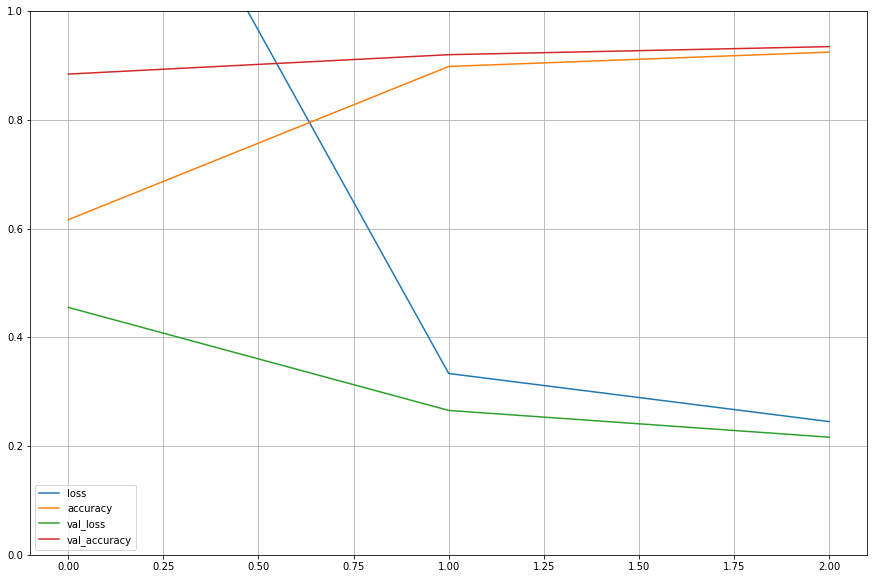

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.grid(True)
plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.show()

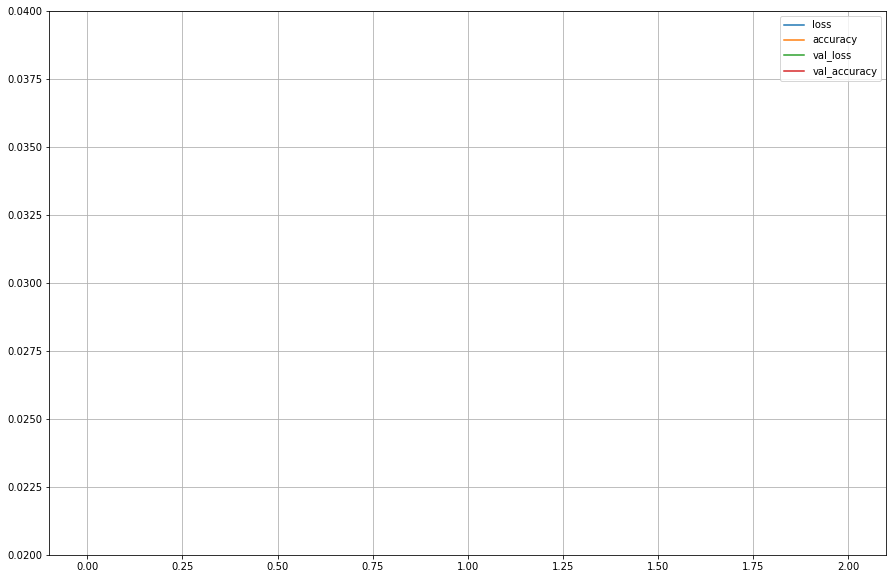

In [11]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.grid(True)
plt.gca().set_ylim(0.02,0.04) # set the vertical range to [0-1]
plt.show()

In [12]:
x_new = x_test
y_proba = model.predict(x_new)
y_proba.round(2)

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.9 , 0.  , 0.  , ..., 0.02, 0.  , 0.  ],
       ...,
       [0.  , 0.86, 0.03, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]], dtype=float32)

In [13]:
y_pred = model.predict_classes(x_new)
y_pred


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, ..., 1, 9, 9], dtype=int64)

In [14]:
y_test[5000:5005]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [15]:
history.history

{'loss': [1.5950387716293335, 0.3335411846637726, 0.24506883323192596],
 'accuracy': [0.6164073944091797, 0.8983333110809326, 0.9247037172317505],
 'val_loss': [0.4551432430744171, 0.26559123396873474, 0.2163861095905304],
 'val_accuracy': [0.8843333125114441, 0.9200000166893005, 0.9348333477973938]}

In [16]:
y_pred=model.predict(x_test) 
y_pred


array([[9.96081650e-01, 3.18487469e-06, 5.53907157e-05, ...,
        2.18481990e-03, 4.47349710e-04, 3.25228575e-05],
       [9.99229312e-01, 7.42683284e-08, 1.50040114e-06, ...,
        1.03327104e-04, 5.56427753e-04, 1.16993749e-06],
       [8.97076607e-01, 4.42952337e-03, 1.04560389e-03, ...,
        2.12189425e-02, 3.12347268e-03, 5.45336923e-04],
       ...,
       [5.93220990e-04, 8.64939868e-01, 2.57035270e-02, ...,
        9.12409159e-04, 1.38029412e-04, 3.44968727e-03],
       [7.48088723e-06, 3.43632820e-07, 1.65722122e-05, ...,
        1.13257030e-07, 1.67957996e-03, 9.96069670e-01],
       [2.65558207e-08, 2.16487564e-10, 6.78733568e-06, ...,
        8.69297700e-09, 2.25132426e-05, 9.98635828e-01]], dtype=float32)

In [17]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)